In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import numpy as np
import uq4pk_src as uq4pk

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Generate Mock Data

In [2]:
np.random.seed(82011)

In [3]:
snr = 300.
Theta_v_true = np.array([-150., 100., 1., 0., 0., -0.2, 0.05])
dv = 30.
lmd_min, lmd_max = 4000., 5000.

In [4]:
ssps = uq4pk.model_grids.MilesSSP(lmd_min=lmd_min, lmd_max=lmd_max)
df = uq4pk.distribution_function.RandomGMM_DistributionFunction(modgrid=ssps, fill_pars={'n':2,
                                                                                         'logsig_lo':-2,
                                                                                         'logsig_hi':-1.5})
op = uq4pk.observation_operator.ObservationOperator(ssps=ssps, dv=dv)
ybar = op.evaluate(df.F, Theta_v_true)
sigma_y = np.mean(np.abs(ybar))/snr
y = np.random.normal(ybar, sigma_y)

Distribution functions should have shape (12, 53)


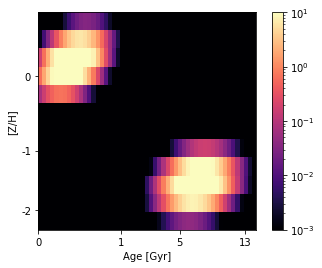

In [5]:
plotter = uq4pk.plotting.Plotter(ssps=ssps, df=df)
plotter.plot_df(view='true', colorbar='true', clim=[1e-3, 10])

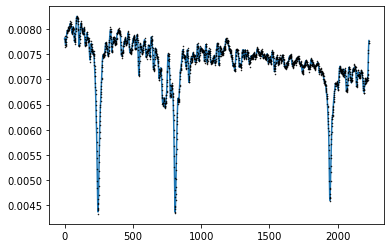

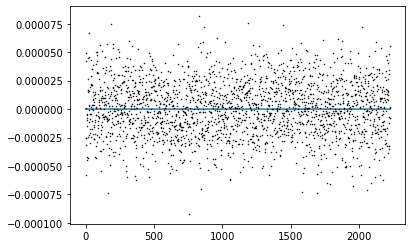

In [6]:
plt.plot(ybar)
plt.plot(y, '.k', ms=1)
plt.show()

plt.plot(ybar-ybar)
plt.plot(y-ybar, '.k', ms=1)
plt.show()

## Pre-processing of SSP templates

Get the SSP templates, multiplied by volume element

In [7]:
m = ssps.F_tilde_s.shape[0]
FXw = np.reshape(ssps.F_tilde_s * ssps.delta_zt, (m,-1))

We will demo SVD-MCMC on the problem where LOSVD parameters are fixed. So let's pre-convolve these by the true LOSVD,

In [8]:
V, sigma, h, M = op.unpack_Theta_v(Theta_v_true)
F_losvd = op.losvd.evaluate_fourier_transform(
    op.H_coeffs,
    V,
    sigma,
    h,
    M,
    op.omega)
FXw_conv = (FXw.T * F_losvd).T
X = np.fft.irfft(FXw_conv, op.ssps.n_fft, axis=0)

Check that the pre-convolved templates $X$ dotted with the true density $f$ re-produces the data,

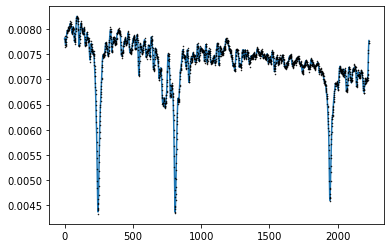

In [9]:
plt.plot(np.dot(X, df.beta))
plt.plot(y, '.k', ms=1)
plt.show()

## Problem Setup

Our problem is now of the form,

$$
y = X \beta + \epsilon
$$

where:

- $X$ is matrix of SSP templates multiplied by the volume element $\Delta t \Delta z$
- $\beta$ is the associated vector of weights, i.e. the discretized and flattened version of $f(t,z)$.

*Notation:* I've chosen $X$ and $\beta$ as they seem to be standard notation for linear regression. Using $\beta$ may also useful when we want to distinguish between 1D and 2D representations of $f$.

## Basic Idea

Say $X$ has shape $(n,p)$. Take the SVD,

$$
X = U \Sigma V^T.
$$

then for some $q<p$, approximate

$$
X \approx Z H
$$

where $Z = U[:,:q] \Sigma[:q, :q]$ and $H = V[:,:q]^T$. The regression now becomes,

$$
y = Z \eta + \epsilon \;\;\;\ (1)
$$

where the $q$-dimensional vector of coefficients $\eta$ is related to the original regression coefficients via

$$
\eta = H \beta. \;\;\;\ (2)
$$

In a generative model for SVD regression, we would define a prior $p(\beta)$ from which we could sample $\beta$, transform to $\eta$, then generate the data via (1). Despite taking a low rank approximation for a $X$, the dimensionality of this model is unchanged from the original problem i.e. we must sample a $p$-dimensional vector $\beta$ and generate $n$-dimensional data $y$.

Instead, we take a different approach which takes advantage of the dimensionality reduction. We define priors directly on $\eta$, then sample the posterior $p(\eta|y)$. The would then be interested in something like 

$$
p(\beta|y) = \int p(\beta|\eta) p(\eta|y) \; \mathrm{d}\eta
$$

However there is no explicit distribution $p(\beta|\eta)$ that we can sample from. We could approximate $p(\beta|\eta)$ by a point-estimate. Example 1, the least-squares solution of (2) but this is not guaranteed to give a non-negative $\beta$. Example 2, use constrianed optimization (NNLS/quad. prog.) to get the least-squares solutiuon of (2) for non-negative $\beta$. Yes, sure. But any point estimate will underestimate uncertainty in the solution. We will only have quantified uncertainty along a $q$-dimensional sub-space of $R^p$ and annihiliated uncertainty in the remaining $p-q$ dimensions.

A solution: sample $p(\beta|\eta)$. But how? We don't have access to this distributiuon. So what! Let's define a probability function to approximate the posterior on beta,

$$
\pi(\beta) \approx p(\beta|y)
$$

which has contruibutions from (1) a regulariser/prior of our choice, and (ii) the posterior $p(\eta|y)$ evaluated at $\eta = H\beta$, i.e.

$$
\log \pi(\beta) = \log p(\beta) + \log p(\eta = H\beta|y) + c
$$

We will choose 

$$
p(\beta) = \mathcal N_{\geq  \mathbf{0}}(0, \boldsymbol{\Sigma}_\beta).
$$

The SVD leads to an uncorrelated posterior on $\eta$,

$$
p(\eta|y) = \mathcal N (\mu_\eta, \mathrm{diag}\{\sigma_\eta\}),
$$

We can sample the $\pi(\beta)$ defined by these log densities.

## A complication: what to do SVD on...?

Columns of $X$ (i.e. volume-element weighted SSP templates) are on different scales,

In [10]:
column_sums = np.sum(X, 0)
print(np.max(column_sums)/np.min(column_sums))

61.296222246027746


This is because stellar populations of different ages produce different amounts of light. Young stars are brighter than  old stars. The SSPS sre normalised such that they are the luminsoity given a unit mass of stars. So $\beta$ are the mass-weights of stellar populations. Physically, we want the mass-weights to give a smooth 2D image, e.g. because a cloud of gas converting to stars as a constant rate will give smooth mass-weights. In other words, we want an isotropic prior $p(\beta)$.

But, the fact that $X$ has column on different scales results in ill-conditioned $p(\eta = H\beta|y)$. Combine this with an isotropic prior $p(\beta)$ using Fabian's suggested rule of thumb regularisation parameter it is still impossible

... show this here, numerically and/or using the analytic solution for a Tikhonov regulariser ...

We could increase the regularisation to fix this... but then the solution is super biased, to be the point it no longer fits the data well. 

Alternative: let's normalise the columns of $X$. Rescaling columns so they have they are on the same scale. This would rescale the regression coefficients to $\tilde{\beta} = D\beta$ where $D$ is a diagonal matrix of scaing factors. $\tilde{\beta}$ are light-weighted SSP templates rather than mass-weighted. But doing this comes at a cost. An isotropic prior $p(\beta)$ e.g.

$$
\beta \sim \mathcal N_{\geq  \mathbf{0}}(0, \boldsymbol{\Sigma}_\beta),
$$

gives an implied prior on $\tilde{\beta}$ of

$$
\tilde{\beta} \sim \mathcal N_{\geq  \mathbf{0}}(0, D \boldsymbol{\Sigma}_\beta D).
$$

The ill-conditioning that was previously in the likelihood is now in the prior - $\pi(\beta)$ is just as impossible to sample from as before.

Where does this leave us? Let's plough ahead, using the normalised $X$ and doing inference on $\tilde{\beta}$. But we are forced to use a prior that is isotropic in $\tilde{\beta}$, not $\beta$. How wrong is this? Well... in this nonparameteric approach, the regulariser is there for smoothness. So... we promote smoothness in light-weights rather than mass-weights: we can live with that. If we want more physical prior, let's use a more physical prior, e.g. informed by our knowledge about star formation histories and chemical evolution of real galaxies. That is a good alternative approach (cite lots of exmaples!) But there is also value in non-parameteric approach (describe these in the intro!), so let's plough ahead.

## The method

Let $x_j$ be the $j$'th column of $X$. Define the normalised template

$$
\tilde{x}_j = \frac{x_j \sum y}{\sum x_j}
$$

where we (i) multiply by the sum of the data in order that regression coefficients remain order unity, and (ii) divide by sum of the template so all templates are on the same scale before we do the SVD. Also define the normalised regression coefficients,

$$
\begin{align}
\tilde{\beta} &= \left[\beta_1 \frac{\sum x_1}{\sum y}, ..., \beta_p \frac{\sum x_p}{\sum y}\right] \\
&:= D \beta
\end{align}
$$

where D is diagonal matrix with $\frac{\sum x_i}{\sum y}$ along the diagonal. The regression is now,

$$
y = [\tilde{x}_1, ...,  \tilde{x}_p] \tilde{\beta} + \epsilon.
$$

Let's also center the matrix. Define the column mean

$$
\mu = \frac{1}{p} \sum_{j=1}^{p} \tilde{x}_j
$$

where $p$ is the number of templates. Introduce the centered and normalised matrix

$$
\tilde{X} = [\tilde{x}_1-\mu_x, ...,  \tilde{x}_p-\mu_x]
$$

so the regression becomes 

$$
y = \alpha \mu_x + \tilde{X} \tilde{\beta} + \epsilon
$$

where

$$
\alpha = \sum \tilde{\beta}.
$$

Since we scaled by the sum of the data, we can expect $\alpha$ to be around 1. Check this:

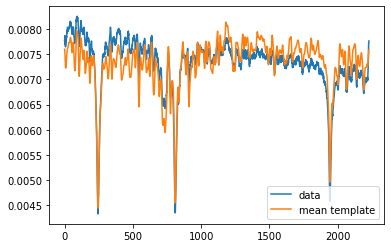

In [11]:
sum_x_j = np.sum(X, 0)
X_tmp = np.sum(y) * X/sum_x_j
mu = np.mean(X_tmp, 1)
X_tilde = (X_tmp.T - mu).T
D = np.diag(sum_x_j/np.sum(y))

plt.plot(y, label='data')
plt.plot(mu, label='mean template')
plt.legend()

Having normalisd and centered, computing the SVD $\tilde{X}$ is equivalent to doing PCA on $X$. Get the SVD of $\tilde{X}$,

$$
\tilde{X} = U \Sigma V^T.
$$

Keep the first $q<<p$ factors

$$
\tilde{X} \approx Z H
$$

as above. The regression now becomes,

$$
y = \alpha \mu_x + Z \eta + \epsilon
$$

where the $q$ dimensional vector of coefficients $\eta$ is related to the original regression coefficients via

$$
\eta = H \tilde{\beta}.
$$

with the constraint that 

$$
\alpha = \sum \tilde{\beta}.
$$

In [12]:
U, Sig, VT = np.linalg.svd(X_tilde)

q = 15 # just pick some value for now
Z = np.dot(U[:,:q], np.diag(Sig[:q]))
H = VT[:q,:]

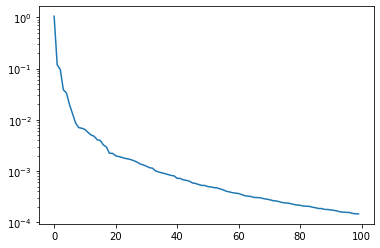

In [13]:
plt.semilogy(Sig[:100])

## Get the prior.

For now let's stick with Fabian's choice for $\boldsymbol{\Sigma}_\beta$: Ornstein-Uhlenbeck covariance with regualrisation parameter $= \mathrm{snr} \cdot 1000$. To get this matrix, lets use Fabian's code,

In [14]:
from uq4pk_fit.inference import StatModel
from simulate_data import load_experiment_data
data = load_experiment_data("experiment_data")
forward_operator = data.get_forward_operator()
model = StatModel(y=y, y_sd=np.ones_like(y)*sigma_y, forward_operator=forward_operator)

/Users/pjethwa/miniconda3/envs/dcdirect/lib/python3.9/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


In [15]:
regularisation_parameter = 1000.*snr
Sigma_beta = (1./regularisation_parameter) * np.dot(model.P1.mat, model.P1.mat.T)

Note... we will be using this as a prior on $\tilde{\beta}$... not $\beta$. See the discussion at the start. Any isotropic prior would do. Also, choice of regularisation_parameter is 

## Inference

$$
\begin{align}
p(\alpha) &\sim \mathcal N (0, \sigma_\alpha) \\
p(\eta) &\sim N (\mathbb{1}_q, \sigma_\eta^2 I_q) \\
p(y | \alpha, \eta ) &\sim \mathcal N (\alpha \mu + Z \eta, \sigma_y) \\
\end{align}
$$

We can sample the $q+1$ dimensional posterior $p(\alpha, \eta | y)$. By the nature of the SVD, this will be an uncorrelated multivariate normal, which can be summarised by posterior parameters $[\mu_\alpha^y, \mu_\eta^y]$ and $[\sigma_\alpha^y, \sigma_\eta^y]$ (all of which depend on the data $y$),

$$
p(\alpha, \eta | y) = \mathcal N ([\mu_\alpha^y, \mu_\eta^y] , \mathrm{diag}([\sigma_\alpha^y, \sigma_\eta^y]) ).
$$

Then infer $\tilde{\beta}$? The probability density function $\pi(\tilde{\beta})$ we'll use

$$
\begin{align}
\pi(\tilde{\beta}) &\approx p(\tilde{\beta} | y) \\
\log \pi(\tilde{\beta}) &= \log p(\tilde{\beta}) + \log \mathcal N \left( \sum \tilde{\beta} ; \mu_\alpha^y, \sigma_\alpha^y \right) + \log \mathcal N \left( H \tilde{\beta} ; \mu_\eta^y, \sigma_\eta^y \right).
\end{align}
$$

Code it up. First sample the posterior $p(\alpha, \eta | y)$,

In [16]:
def svd_datafit_model(q, mu, Z, sigma_y, sigma_alpha=0.1, sigma_eta=0.1, y_obs=None):
    alpha = numpyro.sample("alpha", dist.Normal(1, sigma_alpha))
    eta = numpyro.sample("eta", dist.Normal(0, sigma_eta), sample_shape=(q,))
    ybar = alpha*mu + jnp.dot(Z, eta)
    nrm = dist.Normal(loc=ybar, scale=sigma_y)
    y_obs = numpyro.sample("y_obs", nrm, obs=y_obs)
    return y_obs

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd_datafit_model)
svd_datafit_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [17]:
svd_datafit_mcmc.run(rng_key_, q, mu, Z, sigma_y, y_obs=y)

sample: 100%|█████████████████| 1000/1000 [00:05<00:00, 173.55it/s, 127 steps of size 4.62e-03. acc. prob=0.94]


In [18]:
svd_datafit_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.00      0.00      1.00      1.00      1.00    510.73      1.00
    eta[0]     -0.01      0.00     -0.01     -0.01     -0.01    421.06      1.00
    eta[1]     -0.00      0.00     -0.00     -0.00      0.00    627.05      1.00
    eta[2]     -0.03      0.00     -0.03     -0.03     -0.03    335.19      1.00
    eta[3]      0.00      0.00      0.01      0.00      0.01    592.23      1.00
    eta[4]      0.01      0.00      0.01      0.01      0.01    685.38      1.00
    eta[5]      0.01      0.00      0.01      0.01      0.01    310.51      1.00
    eta[6]     -0.00      0.00     -0.00     -0.00      0.00    177.69      1.00
    eta[7]      0.01      0.00      0.01      0.01      0.02    474.06      1.00
    eta[8]      0.03      0.00      0.03      0.03      0.04    635.59      1.00
    eta[9]      0.04      0.00      0.04      0.03      0.04    117.70      1.00
   eta[10]      0.03      0

That took 6 seconds. Converged - yes? All rhat=1, effective number of samples is high, and 0 divergences. 

Does it fit the data? Let's look at the posterior predictive distribution,

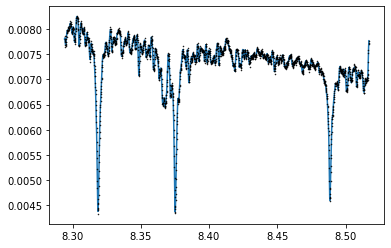

In [19]:
smp = svd_datafit_mcmc.get_samples()
y_smp = mu[np.newaxis,:] * smp['alpha'][:,np.newaxis] + np.dot(Z, smp['eta'].T).T
lo, med, hi = np.percentile(y_smp, [1,50,99], 0)

plt.plot(ssps.w, med)
plt.fill_between(ssps.w, lo, hi, alpha=0.5)
plt.plot(ssps.w, y, '.k', ms=1)

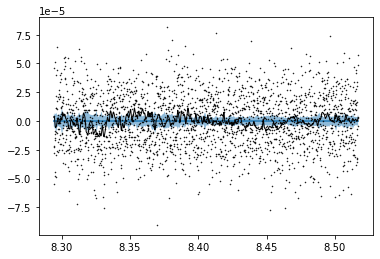

In [20]:
plt.plot(ssps.w, med-med)
plt.fill_between(ssps.w, lo-med, hi-med, alpha=0.5)
plt.plot(ssps.w, y-med, '.k', ms=1)
plt.plot(ssps.w, ybar-med, '-k', lw=1)

And now let's do the deprojection,

In [21]:
def svd_deproject_model(p, mu_eta_y, sigma_eta_y, mu_alpha_y, sigma_alpha_y, H, mu_beta_tilde, Sigma_beta_tilde):
    # hack for non-negativity
    beta_tilde = numpyro.sample("beta_tilde", dist.TruncatedNormal(0, 10., low=0), sample_shape=(p,))
    # from the datafit
    nrm = dist.Normal(mu_eta_y, sigma_eta_y)
    numpyro.factor("likelihood", jnp.sum(nrm.log_prob(jnp.dot(H, beta_tilde))))
    alpha_nrm = dist.Normal(mu_alpha_y, sigma_alpha_y)
    numpyro.factor("normalisation", alpha_nrm.log_prob(jnp.sum(beta_tilde)))
    # prior
    beta_prior = dist.MultivariateNormal(mu_beta_tilde, Sigma_beta_tilde)
    numpyro.factor("regulariser", beta_prior.log_prob(beta_tilde))
    return beta_tilde

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd_deproject_model)
svd_deproject_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

Get the posterior parameters from the data fit

In [22]:
smp = svd_datafit_mcmc.get_samples()
mu_alpha_y, sigma_alpha_y = np.mean(smp['alpha']), np.std(smp['alpha'])
mu_eta_y, sigma_eta_y = np.mean(smp['eta'], 0), np.std(smp['eta'], 0)

In [23]:
p = ssps.X.shape[1]
svd_deproject_mcmc.run(
    rng_key_, p, mu_eta_y, sigma_eta_y, mu_alpha_y, sigma_alpha_y, H, jnp.zeros(p), Sigma_beta
)

sample: 100%|█████████████████| 1000/1000 [04:28<00:00,  3.73it/s, 1023 steps of size 1.39e-03. acc. prob=0.94]


In [24]:
svd_deproject_mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_tilde[0]      0.00      0.00      0.00      0.00      0.00     53.10      1.00
  beta_tilde[1]      0.00      0.00      0.00      0.00      0.00     83.85      1.00
  beta_tilde[2]      0.00      0.00      0.00      0.00      0.00    262.81      1.00
  beta_tilde[3]      0.00      0.00      0.00      0.00      0.00    119.60      1.00
  beta_tilde[4]      0.00      0.00      0.00      0.00      0.00    249.20      1.00
  beta_tilde[5]      0.00      0.00      0.00      0.00      0.00    150.06      1.00
  beta_tilde[6]      0.00      0.00      0.00      0.00      0.00    111.38      1.00
  beta_tilde[7]      0.00      0.00      0.00      0.00      0.00     42.34      1.01
  beta_tilde[8]      0.00      0.00      0.00      0.00      0.01     40.90      1.00
  beta_tilde[9]      0.00      0.00      0.00      0.00      0.01     69.97      1.00
 beta_tilde[10]      0.00      0.00      0.00      0.

It has converged. Some effective sample sizes are a little small (around 50) but we could extend the number of sampling steps. 

How long did it take? Total time = 5s (datafit) + 4m30 (deprojection).

Compared to previous experiments, this is a speedup of factor 4 vs. attempts to sample to full $(n,p)$ dimensional model.

Let's look at posterior predictive. First, only using the first $q$ principal components ,

In [25]:
smp = svd_deproject_mcmc.get_samples()

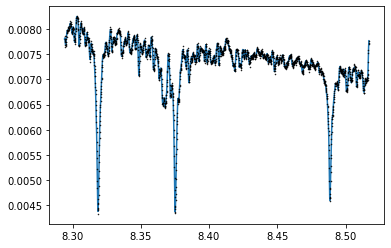

In [26]:
alpha = np.sum(smp['beta_tilde'],1)
eta = np.dot(H, smp['beta_tilde'].T).T
y_smp = alpha[:,np.newaxis]*mu[np.newaxis,:] + np.dot(Z, eta.T).T

plt.fill_between(ssps.w, lo, hi, alpha=0.5)
plt.plot(ssps.w, med)
plt.plot(ssps.w, y, '.k', ms=1)
plt.show()

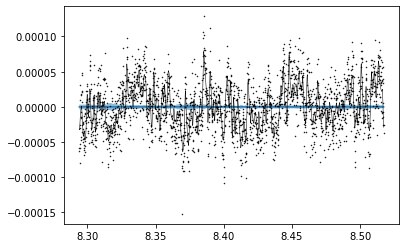

In [27]:
lo, med, hi = np.percentile(y_smp, [1,50,99], 0)
plt.fill_between(ssps.w, lo-med, hi-med, alpha=0.5)
plt.plot(ssps.w, med-med)
plt.plot(ssps.w, ybar-med, '-k', lw=0.5)
plt.plot(ssps.w, y-med, '.k', ms=1)
plt.show()

It looks different wrt the previous posterior check. Why? Still a relatively unbiased fit to the data (i.e.  residuals centered on 0) although they are now correlated. The uncertainites on the posterior-predictive $\bar{y}$ are much smaller than previously though. Probably the regularisation parameter is too strong. Try a more diffuse prior.

$$
\boldsymbol{\Sigma}_\beta \rightarrow 100 \boldsymbol{\Sigma}_\beta
$$

In [28]:
p = ssps.X.shape[1]
svd_deproject_mcmc.run(
    rng_key_, p, mu_eta_y, sigma_eta_y, mu_alpha_y, sigma_alpha_y, H, jnp.zeros(p), 100.*Sigma_beta
)

sample: 100%|█████████████████| 1000/1000 [04:22<00:00,  3.81it/s, 1023 steps of size 8.63e-04. acc. prob=0.93]


In [29]:
svd_deproject_mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_tilde[0]      0.00      0.00      0.00      0.00      0.00     29.69      1.00
  beta_tilde[1]      0.00      0.00      0.00      0.00      0.00     29.35      1.00
  beta_tilde[2]      0.00      0.00      0.00      0.00      0.00     65.45      1.01
  beta_tilde[3]      0.00      0.00      0.00      0.00      0.00     65.26      1.00
  beta_tilde[4]      0.00      0.00      0.00      0.00      0.00     76.94      1.01
  beta_tilde[5]      0.00      0.00      0.00      0.00      0.00     58.13      1.00
  beta_tilde[6]      0.00      0.00      0.00      0.00      0.00     57.58      1.01
  beta_tilde[7]      0.00      0.00      0.00      0.00      0.00     18.97      1.00
  beta_tilde[8]      0.00      0.00      0.00      0.00      0.00     82.92      1.00
  beta_tilde[9]      0.00      0.00      0.00      0.00      0.00    110.14      1.03
 beta_tilde[10]      0.00      0.00      0.00      0.

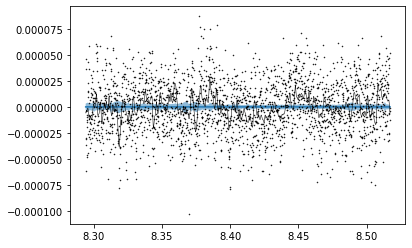

In [30]:
smp_les_reg = svd_deproject_mcmc.get_samples()

alpha = np.sum(smp_les_reg['beta_tilde'],1)
eta = np.dot(H, smp_les_reg['beta_tilde'].T).T
y_smp = alpha[:,np.newaxis]*mu[np.newaxis,:] + np.dot(Z, eta.T).T

lo, med, hi = np.percentile(y_smp, [1,50,99], 0)
plt.fill_between(ssps.w, lo-med, hi-med, alpha=0.5)
plt.plot(ssps.w, med-med)
plt.plot(ssps.w, ybar-med, '-k', lw=0.5)
plt.plot(ssps.w, y-med, '.k', ms=1)
plt.show()

Yes - this is improving, moving in the desired direction.

Finally, rather than doing a posterior predictive check using only the first $q$ principle components, let's use the full parameter space (i.e. generate data using $(\alpha,\eta)$ ony) lets use the inferred $\beta$ directly. Why? If the prior we used for the deprojection too diffuse, then this method could lead to a very different posterior predictive. And that would be bad.

In [31]:
Dinv = np.diag(np.diag(D)**-1)
beta = np.dot(Dinv, smp_les_reg['beta_tilde'].T).T

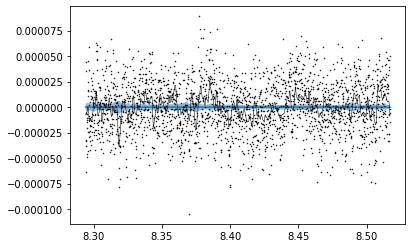

In [32]:
y_smp = np.dot(X, beta.T).T

lo, med, hi = np.percentile(y_smp, [1,50,99], 0)
plt.fill_between(ssps.w, lo-med, hi-med, alpha=0.5)
plt.plot(ssps.w, med-med)
plt.plot(ssps.w, ybar-med, '-k', lw=0.5)
plt.plot(ssps.w, y-med, '.k', ms=1)
plt.show()

Great - it looks the same as above i.e. the prior is not so diffuse as that the inferred beta do not reproduce the data.

We have toyed around with the regularisation parameter here. Too much regularisation and the uncertainties were too small. Too little regularisation (we have not seen this case yet) and the deprojected $\beta$ may not reproduce the data well.

So - how to choose it? (Solution: emperical bayes and/or hyper-prior on regul. parameter).

And how to choose $q$? (Solution: it's always 15 :P. Alternatively, some sort of L-curve test.)

# Visualising the posterior


In [45]:
beta = np.dot(Dinv, smp_les_reg['beta_tilde'].T).T
mysmp = uq4pk.samples.Samples(x=beta)
plotter = uq4pk.plotting.Plotter(ssps=ssps, df=df,  beta_smp=mysmp)

### Ground Truth

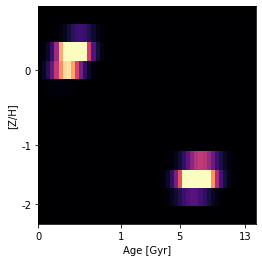

In [55]:
plotter.plot_df(view='true', clim=(0,30), lognorm=False)

### Pixel-wise median

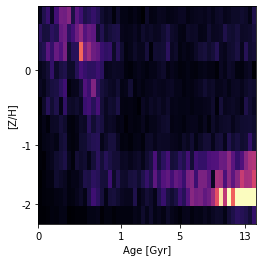

In [51]:
plotter.plot_df(view='median', clim=(0,10), lognorm=False)

### Pixel-wise lower bound (5th-percentile)

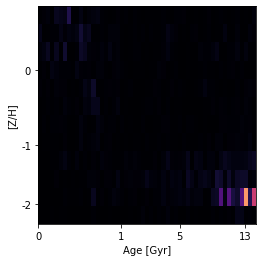

In [56]:
plotter.plot_df(view='percentile', clim=(0,10), percentile=5, lognorm=False)

### Pixel-wise upper credible interval (95th-percentile)

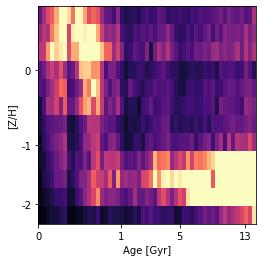

In [59]:
plotter.plot_df(view='percentile', clim=(0,10), percentile=95, lognorm=False)

# Posterior visualisation for the over-regularised solution

### Pixel-wise upper credible interval (95th-percentile)

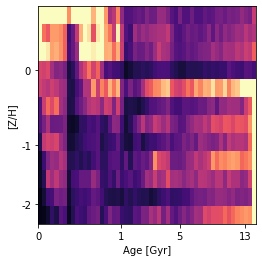

In [60]:
beta = np.dot(Dinv, smp['beta_tilde'].T).T
mysmp = uq4pk.samples.Samples(x=beta)
plotter = uq4pk.plotting.Plotter(ssps=ssps, df=df,  beta_smp=mysmp)
plotter.plot_df(view='percentile', clim=(0,10), percentile=95, lognorm=False)